In [2]:
import networkx as nx
import random
import networkx as nx
from matplotlib import pyplot, patches
from scipy import io
import numpy as np
from collections import defaultdict
import pickle
from tqdm import tqdm
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 

C:\Users\wyw25\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Desgin of the Game:
## 1. finish the model for generate the network without blocks
## 2. simulation function of the empricial network to the model
## 3. generate the network wih blocks
## 4. apply simulation from empricial to the model of blcoks

# The functions for generate network

In [762]:
def assign_colors(Mat):
    
    graph=nx.from_numpy_array(np.array(Mat))
    colors = {0: 0}  # Dictionary to store node colors
    
    # Create a queue with all nodes in the graph
    node_queue = list(graph.nodes())

    while node_queue:
        # Get a list of colors already present in the graph
        existing_colors = list(set(colors.values()))

        current_node = node_queue.pop(0)  # Dequeue a node

        # Check if the node should take the exit color
        if random.random() < 0.9:
            # Choose a random color from the existing colors in the graph
            exit_color = random.choice(existing_colors)
            colors[current_node] = exit_color
          #  graph.nodes[current_node]["label"]= exit_color
        else:
            # Generate a new color (you can replace this with your own color generation logic)
            new_color = len(colors)
            colors[current_node] = new_color
          #  graph.nodes[current_node]["label"]= new_color

        # Update the queue with neighbors of the current node
   #     node_queue.extend(neighbor for neighbor in graph.neighbors(current_node) if neighbor not in colors)

    return colors

In [5]:
def create_label_probability_matrix(labels):
    num_nodes = len(labels)
    
    # Create a square matrix of size num_nodes x num_nodes
    matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):  # Ensure the matrix is symmetric
            # Set the probability for nodes i and j to connect based on their labels
            probability = calculate_probability(labels[i], labels[j])
            matrix[i, j] = probability
            matrix[j, i] = probability  # Since the network is undirected, the matrix is symmetric

    return matrix

def calculate_probability(label_i, label_j):
    # Example: Simple probability calculation, you can customize this based on your requirements
    # Here, we assume a simple rule where nodes with the same label have a higher probability of connection
    if label_i == label_j:
        return 1  # Adjust this probability based on your specific requirements
    else:
        return 0

In [838]:
def Prob_links(Mat,alpha,classify_mat):
    '''
    This function calculate one step for the link generation
    Mat: input matrix 0,1
    alpha: probability for link making, 1- alpha probability for link disappear
    '''
    ks=100000
    
    N=len(Mat)
    incr_m=[[0] * N for row in range(N)]
    decay_m=[[0] * N for row in range(N)]
    # degree for nodes at the beginning of the round
    Degree=np.sum(Mat, axis=0)
   
    for i in range(N):
        Value={}
        Decline={}
        for j in range(i+1,N):  # the node i with j
            if Mat[i][j]==0:  # no link (possible to add a link)
                if classify_mat[i][j]==1: # same class
                    Value[j]= Degree[j]*2 # degree is the value     
                else:
                    Value[j]= Degree[j]*0.2
                    
            if Mat[i][j]==1:  # with link (possible to decline)
                if classify_mat[i][j]==1: # same class
                    Decline[j]=Degree[j]*2 # degree is the value  
                else:
                    Decline[j]=Degree[j]*0.2 # degree is the value
              #  Decline[j]=Degree[j]
                
    #    print(Value)
        max_keys=0
        max_value=0
        if len(Value) >0:
            max_value = max(Value.values())  # maximum value
            max_keys = [k for k, v in Value.items() if v == max_value]  # maximun keys    
    #    print(max_keys)
        # count the number of maxium keys for divider
        if max_keys != 0:
            for k in max_keys:
         #       incr_m[i][k]= alpha/len(max_keys)
         #       incr_m[k][i]= alpha/len(max_keys)
               # incr_m[i][k]=  alpha/Degree[i]
               # incr_m[k][i]=  alpha/Degree[i]
                incr_m[i][k]=  alpha*np.exp((sum(np.array(list(Decline.values())))+max_value)/ks) / sum(np.exp((sum(np.array(list(Decline.values())))+np.array(list(Value.values())))/ks))
                incr_m[k][i]=  alpha*np.exp((sum(np.array(list(Decline.values())))+max_value)/ks) / sum(np.exp((sum(np.array(list(Decline.values())))+np.array(list(Value.values())))/ks))
        #        print((sum(np.array(list(Decline.values())))+max_value)/ks)
        #        print(sum(np.exp((sum(np.array(list(Decline.values())))+np.array(list(Value.values())))/ks)))
        #        print(incr_m[i][k])
        #        print(alpha/len(max_keys))
                
        min_keys=0
        min_value=0
        if len(Decline) >0:
            min_value = min(Decline.values())  # min value
            min_keys = [k for k, v in Decline.items() if v == min_value]    # min keys    
            
        if min_keys != 0:
            for k in min_keys:
          #      decay_m[i][k]= (1 - alpha)/len(min_keys)
          #      decay_m[k][i]= (1 - alpha)/len(min_keys) 
              #  decay_m[i][k]= (1 - alpha)/(N-Degree[i])
              #  decay_m[k][i]= (1 - alpha)/(N-Degree[i])
                decay_m[i][k]= (1 - alpha)*np.exp((sum(np.array(list(Value.values())))+min_value)/ks) / sum(np.exp((sum(np.array(list(Value.values())))+np.array(list(Decline.values())))/ks))
                decay_m[k][i]= (1 - alpha)*np.exp((sum(np.array(list(Value.values())))+min_value)/ks) / sum(np.exp((sum(np.array(list(Value.values())))+np.array(list(Decline.values())))/ks))
  #  print(incr_m)                   
  #  print(decay_m)   
    
    return  incr_m, decay_m


In [7]:
def CreatMat(incr_m,decay_m,Mat):
    B=np.random.rand(*np.array(incr_m).shape)
    B_symm = (B + B.T)/2
    incr_block=incr_m
    decay_block=decay_m
  #  decay_block=decay_m*(classify_mat)
    
    adjacency_add = B_symm  <= np.array(incr_block) # adjacency[ii, jj] is True with probability P[ii, jj]
    adjacency_de = B_symm  <= np.array(decay_block) # adjacency[ii, jj] is True with probability P[ii, jj]
   
    New_Mat= Mat+ adjacency_add*1-adjacency_de*1
           
 #   print(New_Mat)
    return New_Mat.tolist()
    

In [8]:
def Make_stable(Mat,n,alpha,classify_mat): # define classes at beginning
    for i in tqdm(range(n)):
        incr_m,decay_m=Prob_links(Mat,alpha,classify_mat)
        Mat=CreatMat(incr_m,decay_m,Mat)
        
    return Mat

In [520]:
def Make_Ori_Mat(N):
    '''
    This function for initialize a random graph
    '''
    
    MATRIX=np.random.rand(N,N)
    np.fill_diagonal(MATRIX, 0)
    bollmat = 0.5 <= MATRIX
    nummat=1*bollmat
    randmat=np.minimum( nummat, nummat.transpose() )
    
    return randmat.tolist()

In [10]:
def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(10, 10)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth=1))
            current_idx += len(module)

In [11]:
def Get_Order_List(community_dict,degree):
    
    degree_sort={k: v for k, v in sorted(degree.items(), key=lambda item: item[1], reverse=True)}
    degree_list=list(degree_sort.keys())
    
    Comms = defaultdict(list)
    for node_index, comm_id in community_dict.items():
        Comms[comm_id].append(node_index)
    
    Blocks_mark = Comms.values()
    
    nodes_ordered=[]
    key_node_list=[]
    for comm_id in  Comms:
        node_in_block=Comms[comm_id]
        sort_degree_comm=Sort_by_degree(degree_list,node_in_block)
        key_nodes=sort_degree_comm[0]
        key_node_list.append(key_nodes)
        nodes_ordered=nodes_ordered+sort_degree_comm
        
    return Blocks_mark,nodes_ordered,key_node_list

In [12]:
def Sort_by_degree(degree_list,node_in_block):
    
    list2=list(degreeofday_new.keys())
    result = [i for i in degree_list if i in node_in_block]
    
    return result

In [839]:
Mat=Make_Ori_Mat(100)

In [840]:
node_colors=assign_colors(Mat)
node_labels = np.array(list(node_colors.values()))
probability_matrix = create_label_probability_matrix(node_labels)


In [841]:
newmat=Make_stable(Mat,1,0.46,probability_matrix )

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


In [842]:
newmat=Make_stable(newmat,4000,0.46,probability_matrix )

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:21<00:00, 49.07it/s]


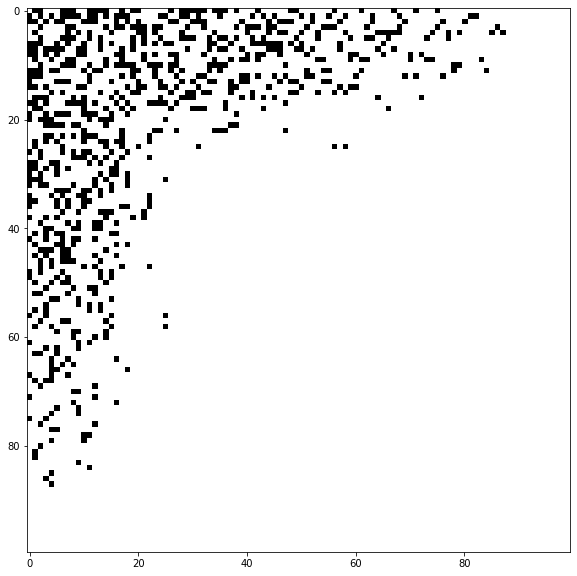

In [843]:
G=nx.from_numpy_matrix(np.array(newmat))
degreeofday=dict(G.degree)
degreeofday_new={k: v for k, v in sorted(degreeofday.items(), key=lambda item: item[1], reverse=True)}
nodenewlist=list(degreeofday_new.keys())
draw_adjacency_matrix(G,nodenewlist)

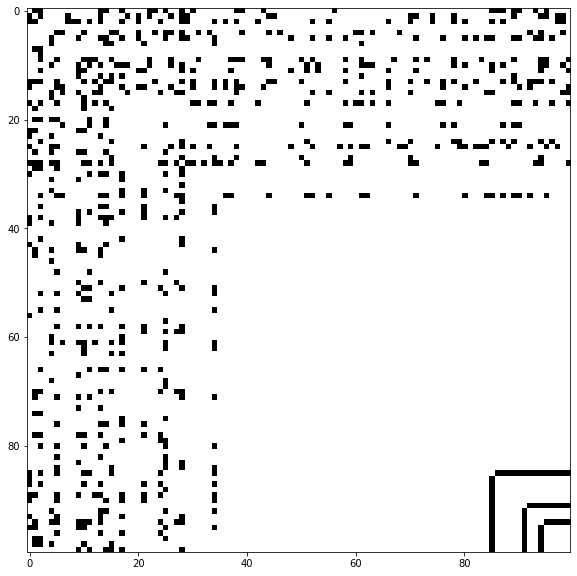

In [844]:
draw_adjacency_matrix(G)

In [845]:
group_dict = node_colors
Q_blocks_mark,Q_ordered,Q_key_node_list=Get_Order_List(group_dict,degreeofday)

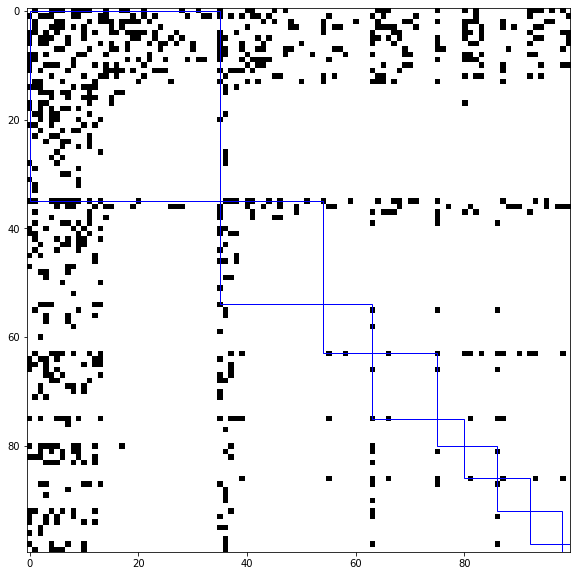

In [846]:
draw_adjacency_matrix(G, Q_ordered,[Q_blocks_mark], ["blue"])

In [847]:
len(Q_blocks_mark)

9

In [237]:
Q_blocks_mark

dict_values([[0, 1, 2, 3, 10, 113, 114, 134, 195], [4, 5, 8, 12, 17, 19, 22, 23, 28, 31, 32, 34, 35, 37, 39, 40, 42, 44, 45, 46, 47, 49, 52, 54, 55, 58, 60, 61, 62, 66, 67, 70, 74, 76, 80, 81, 82, 91, 93, 97, 98, 103, 104, 107, 108, 111, 117, 118, 119, 123, 124, 125, 126, 127, 130, 131, 133, 139, 142, 143, 144, 147, 148, 150, 151, 152, 153, 154, 155, 157, 161, 163, 167, 169, 170, 171, 172, 173, 175, 176, 177, 178, 183, 187, 188, 191, 197], [6, 18, 57, 121, 184], [7, 24, 68, 190, 193], [9, 14, 116, 129, 135, 140, 166, 180, 189], [11, 43, 92, 122, 174], [13, 160, 165], [15, 87, 99, 101, 115, 120], [16, 72, 86, 96, 136], [20, 73, 138, 156], [21, 75, 109, 132, 196], [25, 64, 88, 94, 102], [26, 53, 112, 159, 182, 185, 186, 198], [27, 106, 181], [29, 38, 71, 85, 149, 162, 168], [30, 48, 65, 95, 137, 194], [33, 56, 146], [36, 78, 79, 83, 141, 164], [41, 90, 192], [50, 51, 59, 63, 110, 179, 199], [69, 84, 145, 158], [77, 89, 100, 105, 128]])

In [245]:
node_colors

{0: 0,
 1: 1,
 2: 2,
 3: 2,
 4: 2,
 5: 5,
 6: 2,
 7: 2,
 8: 5,
 9: 1,
 10: 5,
 11: 11,
 12: 1,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 16,
 18: 14,
 19: 15,
 20: 11,
 21: 15,
 22: 22,
 23: 0,
 24: 24,
 25: 14,
 26: 5,
 27: 27,
 28: 28,
 29: 24,
 30: 30,
 31: 31,
 32: 30,
 33: 30,
 34: 34,
 35: 5,
 36: 36,
 37: 24,
 38: 38,
 39: 15,
 40: 38,
 41: 28,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 11,
 47: 34,
 48: 14,
 49: 49,
 50: 50,
 51: 42,
 52: 28,
 53: 30,
 54: 45,
 55: 13,
 56: 36,
 57: 57,
 58: 58,
 59: 59,
 60: 13,
 61: 61,
 62: 62,
 63: 63,
 64: 64,
 65: 65,
 66: 66,
 67: 67,
 68: 68,
 69: 42,
 70: 24,
 71: 58,
 72: 64,
 73: 58,
 74: 22,
 75: 30,
 76: 68,
 77: 45,
 78: 0,
 79: 79,
 80: 28,
 81: 30,
 82: 59,
 83: 24,
 84: 84,
 85: 85,
 86: 86,
 87: 87,
 88: 1,
 89: 89,
 90: 15,
 91: 91,
 92: 34,
 93: 24,
 94: 79,
 95: 65,
 96: 16,
 97: 42,
 98: 98,
 99: 59,
 100: 91,
 101: 87,
 102: 102,
 103: 103,
 104: 104,
 105: 105,
 106: 106,
 107: 107,
 108: 91,
 109: 109,
 110: 110,
 111: 44,

In [148]:
Mat

[[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1],
 [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,

In [150]:
incr_m, decay_m=Prob_links(Mat,0.5)

In [152]:
decay_m

[[0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0.5, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.16666666666666666,
  0,
  0,
  0,
  0,
  0.16666666666666666,
  0,
  0,
  0,
  0,
  0.16666666666666666],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0.25, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0],
 [0,
  0,
  0,
  0,
  0,
  0.5,
  0.16666666666666666,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.16666666666666666,
  0,
  0.16666666666666666,
  0,
  0,
  0.16666666666666666],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0],
 [0, 0

In [151]:
incr_m

[[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0.16666666666666666,
  0,
  0,
  0,
  0.16666666666666666,
  0,
  0,
  0.16666666666666666,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0.16666666666666666,
  0,
  0.5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0.25, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0.25, 0, 0, 0, 0, 0, 0],
 [0,
  0,
  0,
  0,
  0,
  0.16666666666666666,
  0,
  0,
  0.25,
  0.25,
  0,
  0,
  0,
  0,
  0.25,
  0,
  0.25,
  0,
  0,
  0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0

In [ ]:
G.nodes[0]["label"] = "A"

In [41]:
def assign_colors(graph):
    colors = {0: 0}  # Dictionary to store node colors
    
    # Create a queue with all nodes in the graph
    node_queue = list(graph.nodes())

    while node_queue:
        # Get a list of colors already present in the graph
        existing_colors = list(set(colors.values()))

        current_node = node_queue.pop(0)  # Dequeue a node

        # Check if the node should take the exit color
        if random.random() < 0.7:
            # Choose a random color from the existing colors in the graph
            exit_color = random.choice(existing_colors)
            colors[current_node] = exit_color
            graph.nodes[current_node]["label"]= exit_color
        else:
            # Generate a new color (you can replace this with your own color generation logic)
            new_color = len(colors)
            colors[current_node] = new_color
            graph.nodes[current_node]["label"]= new_color

        # Update the queue with neighbors of the current node
        node_queue.extend(neighbor for neighbor in graph.neighbors(current_node) if neighbor not in colors)

    return graph

In [54]:
# Example usage:
# Create an empty undirected graph with n nodes
n = 100
graph = nx.empty_graph(n)

# Assign colors based on the specified rule
node_colors = assign_colors(graph)


In [49]:
node_colors.nodes[4]["label"] 

0

In [ ]:
# select nodes of same labels and add them with probability

In [67]:
def create_label_probability_matrix(labels):
    num_nodes = len(labels)
    
    # Create a square matrix of size num_nodes x num_nodes
    matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):  # Ensure the matrix is symmetric
            # Set the probability for nodes i and j to connect based on their labels
            probability = calculate_probability(labels[i], labels[j])
            matrix[i, j] = probability
            matrix[j, i] = probability  # Since the network is undirected, the matrix is symmetric

    return matrix

def calculate_probability(label_i, label_j):
    # Example: Simple probability calculation, you can customize this based on your requirements
    # Here, we assume a simple rule where nodes with the same label have a higher probability of connection
    if label_i == label_j:
        return 0.8  # Adjust this probability based on your specific requirements
    else:
        return 0.2

# Example usage
node_labels = np.array(list(node_colors.values()))
probability_matrix = create_label_probability_matrix(node_labels)

# Print the result
print("Label Probability Matrix:")
print(probability_matrix)

Label Probability Matrix:
[[0.  0.8 0.8 ... 0.2 0.8 0.2]
 [0.8 0.  0.8 ... 0.2 0.8 0.2]
 [0.8 0.8 0.  ... 0.2 0.8 0.2]
 ...
 [0.2 0.2 0.2 ... 0.  0.2 0.8]
 [0.8 0.8 0.8 ... 0.2 0.  0.2]
 [0.2 0.2 0.2 ... 0.8 0.2 0. ]]


In [68]:
1-probability_matrix

array([[1. , 0.2, 0.2, ..., 0.8, 0.2, 0.8],
       [0.2, 1. , 0.2, ..., 0.8, 0.2, 0.8],
       [0.2, 0.2, 1. , ..., 0.8, 0.2, 0.8],
       ...,
       [0.8, 0.8, 0.8, ..., 1. , 0.8, 0.2],
       [0.2, 0.2, 0.2, ..., 0.8, 1. , 0.8],
       [0.8, 0.8, 0.8, ..., 0.2, 0.8, 1. ]])

In [239]:
def assign_colors(graph):
    colors = {0: 0}  # Dictionary to store node colors
    
    # Create a queue with all nodes in the graph
    node_queue = list(graph.nodes())

    while node_queue:
        # Get a list of colors already present in the graph
        existing_colors = list(set(colors.values()))

        current_node = node_queue.pop(0)  # Dequeue a node

        # Check if the node should take the exit color
        if random.random() < 0.7:
            # Choose a random color from the existing colors in the graph
            exit_color = random.choice(existing_colors)
            colors[current_node] = exit_color
        else:
            # Generate a new color (you can replace this with your own color generation logic)
            new_color = len(colors)
            colors[current_node] = new_color

        # Update the queue with neighbors of the current node
        node_queue.extend(neighbor for neighbor in graph.neighbors(current_node) if neighbor not in colors)

    return colors


In [240]:
# Example usage:
# Create an empty undirected graph with n nodes
n = 100
graph = nx.empty_graph(n)

# Assign colors based on the specified rule
node_colors = assign_colors(graph)


In [241]:
np.array(list(node_colors.values()))

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10, 10,  1,  1, 10, 15,  1,
       17, 15, 17, 15,  1,  1, 15, 24,  1, 15,  1, 28, 24,  1, 15, 24, 33,
       34, 35, 34, 10, 28, 33,  1, 41, 42, 33, 44, 41, 24, 24,  1, 42, 17,
       10, 17, 15, 28, 34, 42, 41, 15,  1, 60, 61, 44, 63, 33, 65, 60, 28,
       42, 33, 70,  1, 72, 60, 63, 75, 75, 70,  1,  1, 80, 61, 82, 63, 60,
       60, 33, 28, 75, 82, 28, 28, 65, 93, 15, 33, 80, 63, 98, 44])

In [36]:
len(set(node_colors.values()))

30